# CNN Upgraded

Notebook para la nueva versión del modelo CNN basado en: (1) dataset enriquecido, (2) pipeline `tf.data`/TFRecords, (3) aprendizaje multitarea (clasificación + regresión de centipawns).

In [2]:
import sys
import math
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
import pyarrow.parquet as pq

sys.path.append('..')
from functions.fen_analyzer import extract_active_turn

print('TensorFlow version:', tf.__version__)


TensorFlow version: 2.20.0


In [16]:
# Rutas y parámetros base
PROCESSED_DIR = Path('..') / 'data' / 'processed' / 'enriched'
TFRECORD_DIR = Path('..') / 'data' / 'tfrecords'
TFRECORD_DIR.mkdir(parents=True, exist_ok=True)

BOARD_SHAPE = (8, 8, 12)
AUX_FEATURES = [
    'material_difference', 'total_pieces', 'pawn_advantage', 'rook_advantage',
    'bishop_advantage', 'knight_advantage', 'queen_advantage', 'white_material', 'black_material'
]
TARGET_CLASS_COL = 'eval_class_active'
TARGET_REG_COL = 'evaluation_cp_clipped'
BATCH_SIZE = 256
AUTOTUNE = tf.data.AUTOTUNE
MAX_TRAIN = 350_000
MAX_VAL = 42_000
MAX_TEST = 42_000
REG_LOSS_WEIGHT = 0.05
SIGNED_AUX_FEATURES = {
    'material_difference',
    'pawn_advantage',
    'rook_advantage',
    'bishop_advantage',
    'knight_advantage',
    'queen_advantage',
}


## 1. Exportar TFRecords desde el dataset enriquecido

In [17]:
PIECE_MAP = {p: i for i, p in enumerate(['P','N','B','R','Q','K'])}
CHANNELS = len(PIECE_MAP) * 2
SPLIT_SIZES = {}

def fen_to_tensor(fen: str) -> tuple[np.ndarray, bool]:
    parts = fen.split(' ')
    board_field = parts[0]
    active = parts[1] if len(parts) > 1 else 'w'
    is_black_turn = active.lower() == 'b'

    board_proc = board_field.swapcase() if is_black_turn else board_field
    rows = board_proc.split('/')
    if is_black_turn:
        rows = list(reversed(rows))

    tensor_rows = []
    for rank in rows:
        row_vecs = []
        for ch in rank:
            vec = [0] * CHANNELS
            if ch.isdigit():
                for _ in range(int(ch)):
                    row_vecs.append(vec.copy())
                continue
            lookup = ch.upper()
            if lookup in PIECE_MAP:
                offset = PIECE_MAP[lookup]
                if ch.isupper():
                    vec[offset] = 1
                else:
                    vec[offset + len(PIECE_MAP)] = 1
            row_vecs.append(vec)
        tensor_rows.append(row_vecs)
    return np.array(tensor_rows, dtype=np.float32), is_black_turn

def to_example(row: pd.Series) -> tf.train.Example:
    tensor, is_black_turn = fen_to_tensor(row['FEN'])
    tensor_flat = tensor.flatten().astype(np.float32)

    aux_values = {col: float(row[col]) for col in AUX_FEATURES}
    if is_black_turn:
        for col in SIGNED_AUX_FEATURES:
            if col in aux_values:
                aux_values[col] = -aux_values[col]
        aux_values['white_material'], aux_values['black_material'] = (
            aux_values['black_material'],
            aux_values['white_material'],
        )

    feature = {
        'board': tf.train.Feature(float_list=tf.train.FloatList(value=tensor_flat)),
        TARGET_CLASS_COL: tf.train.Feature(int64_list=tf.train.Int64List(value=[int(row[TARGET_CLASS_COL])])),
        TARGET_REG_COL: tf.train.Feature(float_list=tf.train.FloatList(value=[float(row[TARGET_REG_COL])])),
    }
    for col in AUX_FEATURES:
        feature[col] = tf.train.Feature(float_list=tf.train.FloatList(value=[aux_values[col]]))
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecord(split: str, limit: int | None = None, batch_size: int = 50_000):
    """Exporta el split a TFRecord sin cargar todo el parquet en memoria."""
    input_path = PROCESSED_DIR / f'{split}_enriched.parquet'
    assert input_path.exists(), f'No se encontró {input_path}'

    pf = pq.ParquetFile(input_path)
    required_columns = ['FEN', TARGET_CLASS_COL, TARGET_REG_COL, *AUX_FEATURES]
    total_rows = pf.metadata.num_rows if pf.metadata is not None else None

    selected_positions = None
    if limit is not None and total_rows is not None and limit < total_rows:
        rng = np.random.default_rng(42)
        selected_positions = np.sort(rng.choice(total_rows, size=limit, replace=False))
    elif limit is not None and total_rows is not None:
        limit = min(limit, total_rows)

    rows_written = 0
    next_selected_idx = 0
    current_global_index = 0

    output_path = TFRECORD_DIR / f'{split}.tfrecord'
    with tf.io.TFRecordWriter(str(output_path)) as writer:
        for batch in pf.iter_batches(columns=required_columns, batch_size=batch_size):
            batch_df = batch.to_pandas(ignore_metadata=True)
            batch_len = len(batch_df)

            if selected_positions is not None:
                batch_end = current_global_index + batch_len
                indices = []
                while next_selected_idx < len(selected_positions) and selected_positions[next_selected_idx] < batch_end:
                    relative_idx = int(selected_positions[next_selected_idx] - current_global_index)
                    indices.append(relative_idx)
                    next_selected_idx += 1
                if not indices:
                    current_global_index += batch_len
                    continue
                batch_df = batch_df.iloc[indices]
            elif limit is not None:
                remaining = limit - rows_written
                if remaining <= 0:
                    break
                if remaining < len(batch_df):
                    batch_df = batch_df.iloc[:remaining]

            for _, row in batch_df.iterrows():
                example = to_example(row)
                writer.write(example.SerializeToString())
                rows_written += 1

            current_global_index += batch_len
            if limit is not None and rows_written >= limit:
                break

    SPLIT_SIZES[split] = rows_written
    print(f"{split}: {rows_written:,} ejemplos -> {output_path}")


In [18]:
write_tfrecord('training', MAX_TRAIN)
write_tfrecord('validation', MAX_VAL)
write_tfrecord('testing', MAX_TEST)


training: 350,000 ejemplos -> ..\data\tfrecords\training.tfrecord
validation: 42,000 ejemplos -> ..\data\tfrecords\validation.tfrecord
testing: 42,000 ejemplos -> ..\data\tfrecords\testing.tfrecord


In [19]:
TRAIN_STEPS = math.ceil(SPLIT_SIZES['training'] / BATCH_SIZE)
VAL_STEPS = math.ceil(SPLIT_SIZES['validation'] / BATCH_SIZE)
TEST_STEPS = math.ceil(SPLIT_SIZES['testing'] / BATCH_SIZE)
print(f"Steps/epoch → train: {TRAIN_STEPS:,}, val: {VAL_STEPS:,}, test: {TEST_STEPS:,}")

Steps/epoch → train: 1,368, val: 165, test: 165


## 2. Pipeline `tf.data` con augmentación por simetrías

In [20]:
feature_description = {
    'board': tf.io.FixedLenFeature([BOARD_SHAPE[0] * BOARD_SHAPE[1] * BOARD_SHAPE[2]], tf.float32),
    TARGET_CLASS_COL: tf.io.FixedLenFeature([], tf.int64),
    TARGET_REG_COL: tf.io.FixedLenFeature([], tf.float32),
}
for col in AUX_FEATURES:
    feature_description[col] = tf.io.FixedLenFeature([], tf.float32)

def parse_example(serialized):
    parsed = tf.io.parse_single_example(serialized, feature_description)
    board = tf.reshape(parsed.pop('board'), BOARD_SHAPE)
    class_id = tf.cast(parsed.pop(TARGET_CLASS_COL), tf.int32)
    reg_target = parsed.pop(TARGET_REG_COL)
    class_label = tf.one_hot(class_id, 3)
    aux_vec = tf.stack([parsed[col] for col in AUX_FEATURES], axis=-1)
    return (board, aux_vec), (class_label, reg_target)

def augment(board, aux):
    if tf.random.uniform([]) > 0.5:
        board = tf.image.flip_left_right(board)
    if tf.random.uniform([]) > 0.5:
        board = tf.image.flip_up_down(board)
    board = tf.ensure_shape(board, BOARD_SHAPE)
    return board, aux

def make_dataset(split: str, batch_size: int, training: bool = True):
    tfrecord_path = TFRECORD_DIR / f'{split}.tfrecord'
    ds = tf.data.TFRecordDataset(str(tfrecord_path))
    ds = ds.map(parse_example, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(10_000)
    ds = ds.repeat()
    if training:
        def _map(features, labels):
            board_aug, aux_aug = augment(features[0], features[1])
            return (board_aug, aux_aug), labels
        ds = ds.map(_map, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


## 3. Modelo multitarea (clasificación + regresión)

In [21]:
from keras import layers, models, regularizers

def build_multitask_model(board_shape=BOARD_SHAPE, aux_dim=len(AUX_FEATURES), l2w=1e-4, dropout=0.3):
    board_input = layers.Input(shape=board_shape, name='board_input')
    aux_input = layers.Input(shape=(aux_dim,), name='aux_input')

    x = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2w))(board_input)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2w))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2w))(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)

    aux_branch = layers.Dense(64, activation='relu')(aux_input)
    aux_branch = layers.Dropout(dropout)(aux_branch)

    merged = layers.concatenate([x, aux_branch])
    shared = layers.Dense(128, activation='relu')(merged)
    shared = layers.Dropout(dropout)(shared)

    class_head = layers.Dense(64, activation='relu')(shared)
    class_output = layers.Dense(3, activation='softmax', name='class_head')(class_head)

    reg_head = layers.Dense(64, activation='relu')(shared)
    reg_output = layers.Dense(1, activation='linear', name='reg_head')(reg_head)

    model = models.Model(inputs=[board_input, aux_input], outputs=[class_output, reg_output])
    model.compile(
        optimizer='adam',
        loss={'class_head': 'categorical_crossentropy', 'reg_head': 'mae'},
        loss_weights={'class_head': 1.0, 'reg_head': REG_LOSS_WEIGHT},
        metrics={'class_head': ['accuracy', tf.keras.metrics.AUC(name='auc', multi_label=False)],
                 'reg_head': ['mae', 'mse']}
    )
    return model

model = build_multitask_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ board_input         │ (None, 8, 8, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 128) │     13,952 │ board_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 4, 4, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 256) │    295,168 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 256) │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aux_input           │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │        640 │ aux_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 320)       │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     41,088 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_head (Dense)  │ (None, 3)         │        195 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reg_head (Dense)    │ (None, 1)         │         65 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 517,252 (1.97 MB)

 Trainable params: 516,228 (1.97 MB)

 Non-trainable params: 1,024 (4.00 KB)

## 4. Entrenamiento y evaluación

In [22]:
train_ds = make_dataset('training', BATCH_SIZE, training=True)
val_ds = make_dataset('validation', BATCH_SIZE, training=False)
test_ds = make_dataset('testing', BATCH_SIZE, training=False)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_class_head_accuracy', mode='max', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_class_head_accuracy', mode='max', factor=0.5, patience=3, min_lr=1e-5),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    steps_per_epoch=TRAIN_STEPS,
    validation_steps=VAL_STEPS,
    callbacks=callbacks
)

eval_results = model.evaluate(test_ds, steps=TEST_STEPS)
print('Test metrics:', eval_results)

pred_class, pred_cp = model.predict(test_ds, steps=TEST_STEPS)


Epoch 1/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 100s 71ms/step - class_head_accuracy: 0.5914 - class_head_auc: 0.7767 - class_head_loss: 0.8833 - loss: 16.9812 - reg_head_loss: 321.0448 - reg_head_mae: 321.0448 - reg_head_mse: 258872.3438 - val_class_head_accuracy: 0.6307 - val_class_head_auc: 0.8149 - val_class_head_loss: 0.8075 - val_loss: 16.7719 - val_reg_head_loss: 317.9871 - val_reg_head_mae: 317.9871 - val_reg_head_mse: 257933.1094 - learning_rate: 0.0010
Epoch 2/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 97s 71ms/step - class_head_accuracy: 0.6318 - class_head_auc: 0.8134 - class_head_loss: 0.8136 - loss: 16.6967 - reg_head_loss: 315.8666 - reg_head_mae: 315.8666 - reg_head_mse: 255790.7188 - val_class_head_accuracy: 0.6428 - val_class_head_auc: 0.8269 - val_class_head_loss: 0.7943 - val_loss: 16.5383 - val_reg_head_loss: 312.6192 - val_reg_head_mae: 312.6192 - val_reg_head_mse: 252862.4219 - learning_rate: 0.0010
Epoch 3/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 96s 70ms/step - class_head_accuracy: 

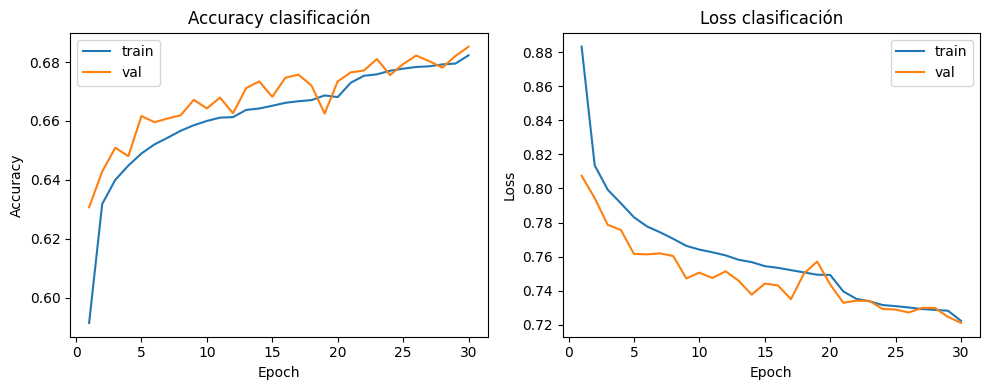

In [23]:
import matplotlib.pyplot as plt

history_dict = history.history if history is not None else {}
epochs = range(1, len(history_dict.get('class_head_accuracy', [])) + 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(epochs, history_dict.get('class_head_accuracy', []), label='train')
axes[0].plot(epochs, history_dict.get('val_class_head_accuracy', []), label='val')
axes[0].set_title('Accuracy clasificación')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, history_dict.get('class_head_loss', []), label='train')
axes[1].plot(epochs, history_dict.get('val_class_head_loss', []), label='val')
axes[1].set_title('Loss clasificación')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

     Ventaja       0.68      0.54      0.60     12650
      Empate       0.72      0.81      0.76     20176
  Desventaja       0.60      0.62      0.61      9414

    accuracy                           0.68     42240
   macro avg       0.67      0.66      0.66     42240
weighted avg       0.68      0.68      0.68     42240



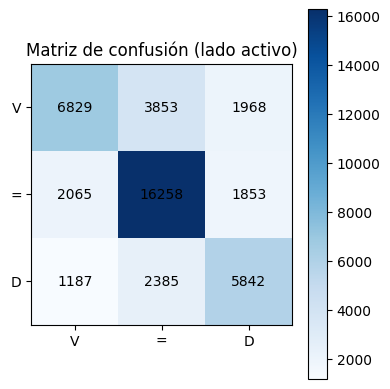

Clasificación samples: 42,240 | Regresión MAE: 295.6 cp | RMSE: 492.5 cp


In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error

def collect_true_labels(dataset, steps):
    cls_list, reg_list = [], []
    for (_, _), (cls, reg) in dataset.take(steps):
        cls_list.append(cls.numpy())
        reg_list.append(reg.numpy())
    y_cls = np.concatenate(cls_list, axis=0)
    y_reg = np.concatenate(reg_list, axis=0)
    return y_cls, y_reg

y_true_cls_onehot, y_true_reg = collect_true_labels(test_ds, TEST_STEPS)
y_true_cls = np.argmax(y_true_cls_onehot, axis=1)
y_pred_cls = np.argmax(pred_class, axis=1)

print(classification_report(y_true_cls, y_pred_cls, target_names=['Ventaja','Empate','Desventaja']))
cm = confusion_matrix(y_true_cls, y_pred_cls)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
ax.set_xticklabels(['V','=', 'D']); ax.set_yticklabels(['V','=', 'D'])
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center')
ax.set_title('Matriz de confusión (lado activo)')
plt.colorbar(im); plt.tight_layout(); plt.show()

y_true_reg_flat = y_true_reg.squeeze()
y_pred_reg_flat = pred_cp.squeeze()
mae = mean_absolute_error(y_true_reg_flat, y_pred_reg_flat)
rmse = mean_squared_error(y_true_reg_flat, y_pred_reg_flat) ** 0.5
print(f'Clasificación samples: {len(y_true_cls):,} | Regresión MAE: {mae:.1f} cp | RMSE: {rmse:.1f} cp')
